## Max-Sum

In [114]:
include("../code/bp_full_gfq.jl")
using StaticArrays

In [7]:
hamming(x,y) = count_ones((x-1) ⊻ (y-1))

hamming (generic function with 1 method)

In [17]:
msg_sum(u1::SVector, u2::SVector) = u1 .+ u2
normalize_max(u::SVector) = u .- maximum(u)
function neutral_prob_ms(Q::Integer)
    v = -Inf*ones(SVector{Q})
    v = setindex(v, 0.0, 1)
end

neutral_prob_ms (generic function with 1 method)

In [197]:
function iter_var_ms(us, s::Int, Q)
    h = - hamming.(SVector{Q}(1:Q), s)
    for u in us
        h = msg_sum(h, u)
    end
    h
end

iter_var_ms (generic function with 2 methods)

In [28]:
function msg_maxconv_gfq!(u::MVector{Q,T}, h1::SVector{Q,T}, h2::SVector{Q,T}) where {Q,T}
    for x1 in eachindex(h1), x2 in eachindex(h2)
        # adjust for indices starting at 1 instead of 0
        u[((x1-1) ⊻ (x2-1)) + 1] = max(u[((x1-1) ⊻ (x2-1)) + 1], h1[x1]+h2[x2])
    end
    SVector(u)
end

msg_maxconv_gfq! (generic function with 1 method)

In [212]:
function iter_factor_ms(hs, Hs, H0, gfmult, gfdiv, Q)
    uaux = -Inf*ones(MVector{Q,Float64})
    u_tilde = neutral_prob_ms(Q)
    for (h,H) in zip(hs,Hs)
        h_tilde = h[SVector{Q}(gfdiv[:,H])]
        uaux .= -Inf
        u_tilde = msg_maxconv_gfq!(uaux, u_tilde, h_tilde)
    end
    u = u_tilde[SVector{Q}(gfmult[:,H0])]
end

iter_factor_ms (generic function with 2 methods)

In [30]:
 gfmult = SA[1 1 1 1;
                1 2 3 4;
                1 3 4 2;
                1 4 2 3]
    gfdiv = SA[0 1 1 1;
               0 2 4 3;
               0 3 2 4;
               0 4 3 2]  

4×4 SMatrix{4, 4, Int64, 16} with indices SOneTo(4)×SOneTo(4):
 0  1  1  1
 0  2  4  3
 0  3  2  4
 0  4  3  2

In [31]:
h1 = SVector{Q}(1.0,2.0,3.0,4.0)
h2 = SVector{Q}(5.0,6.0,7.0,8.0)
Hs = [3,4]
H0 = 2
hs = [h1, h2]
iter_factor_ms(hs, Hs, H0, gfmult, gfdiv)

4-element SVector{4, Float64} with indices SOneTo(4):
 11.0
 11.0
 10.0
 12.0

In [213]:
function RS_gfq(Λ, Pk, Q, popP, popQ, gfmult, gfdiv; maxiter=10^2, tol=1e-5, 
        toliter=1/length(popP)) 
    ks = [k for k in eachindex(Pk) if Pk[k] > tol]
    ds = [d for d in eachindex(Λ) if Λ[d] > tol]
    @assert sum(Pk[ks]) ≈ 1 && sum(Λ[ds]) ≈ 1    
    Λ_red = [d*Λ[d] for d in eachindex(Λ)]; Λ_red ./= sum(Λ_red)
    P_red = [d*Pk[d] for d in eachindex(Pk)]; P_red ./= sum(P_red)
    
    N = length(popP)
    avgP = mean(popP)
    for it in 1:maxiter
        # update Q
        for i in 1:N
            d = sample(eachindex(Λ_red), weights(Λ_red))
            s = rand(1:Q)
            idx = sample(1:N, d-1)
            h = iter_var_ms(popP[idx], s, Q)
            popQ[i] = h .- maximum(h)
        end
        # update P(u)
        for i in 1:N
            k = sample(eachindex(P_red), weights(P_red))
            Hs = rand(2:Q,k-1)
            H0 = rand(2:Q)
            idx = sample(1:N, k-1)
            u = iter_factor_ms(popQ[idx], Hs, H0, gfmult, gfdiv, Q)
            popP[i] = u .- maximum(u)
        end
        avgP_old = avgP
        avgP = mean(popP)
        err = maximum(abs.(avgP_old.-avgP))
        @show err, toliter, avgP
        if err < toliter
            break
        end
    end
    
end

RS_gfq (generic function with 1 method)

In [214]:
function freenrj_factor(popQ, Pk, gfmult, gfdiv, Q)
    N=length(popQ)
    k = sample(eachindex(Pk), weights(Pk))
    Hs = rand(2:Q,k)
    idx = sample(1:N, k)
    hs=popQ[idx]
    u = iter_factor_ms(hs, Hs, 1, gfmult, gfdiv, Q)
    Fa = -u[1]
end
function freenrj_edge(popP, popQ)
    N=length(popP)
    h=popQ[rand(1:N)]
    u=popP[rand(1:N)]
    Fia = -maximum(msg_sum(h, u))
end
function freenrj_var(Λ, popP, Q)
    N = length(popP)
    d = sample(eachindex(Λ), weights(Λ))
    s = rand(1:Q)
    idx = sample(1:N, d)
    us = popP[idx]
    Fi = -maximum(iter_var_ms(us, s, Q))
end

function freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv; samples=10^3)
    mK = sum(k*Pk[k] for k=eachindex(Pk))
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK
    Fa=Fi=Fia=0 
    for t=1:samples
        Fa += freenrj_factor(popQ, Pk, gfmult, gfdiv, Q)
        Fi += freenrj_var(Λ, popP, Q)
        Fia += freenrj_edge(popP, popQ)
        F = (Fi + α*Fa - mΛ*Fia)/t/log2(Q)
        @show Fi/t/log2(Q), α*Fa/t/log2(Q), -mΛ*Fia/t/log2(Q)
    end
    F = (Fi + α*Fa - mΛ*Fia)/samples/log2(Q)
end

freenrj (generic function with 1 method)

In [208]:
Q = 2
gfmult, gfdiv = gftables(Val(Q))
N=10^3
maxiter = 10^3
popP = fill(zero(SVector{Q}), N)
popQ = fill(zero(SVector{Q}), N)
Λ = [0.5,0.5]
Pk = [0,1,0]
RS_gfq(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, maxiter=maxiter)

(err, toliter, avgP) = (0.543, 0.001, [-0.457, -0.543])
(err, toliter, avgP) = (0.008000000000000007, 0.001, [-0.449, -0.544])
(err, toliter, avgP) = (0.11799999999999994, 0.001, [-0.567, -0.592])
(err, toliter, avgP) = (0.03500000000000003, 0.001, [-0.602, -0.605])
(err, toliter, avgP) = (0.05500000000000005, 0.001, [-0.657, -0.605])
(err, toliter, avgP) = (0.039999999999999925, 0.001, [-0.697, -0.626])
(err, toliter, avgP) = (0.03500000000000003, 0.001, [-0.685, -0.591])
(err, toliter, avgP) = (0.09199999999999997, 0.001, [-0.777, -0.633])
(err, toliter, avgP) = (0.049000000000000044, 0.001, [-0.728, -0.622])
(err, toliter, avgP) = (0.03400000000000003, 0.001, [-0.762, -0.64])
(err, toliter, avgP) = (0.038000000000000034, 0.001, [-0.773, -0.602])
(err, toliter, avgP) = (0.008000000000000007, 0.001, [-0.767, -0.61])
(err, toliter, avgP) = (0.11399999999999999, 0.001, [-0.653, -0.626])
(err, toliter, avgP) = (0.015000000000000013, 0.001, [-0.658, -0.641])
(err, toliter, avgP) = (0.0749

(err, toliter, avgP) = (0.04500000000000004, 0.001, [-0.731, -0.635])
(err, toliter, avgP) = (0.07399999999999995, 0.001, [-0.657, -0.673])
(err, toliter, avgP) = (0.03400000000000003, 0.001, [-0.623, -0.701])
(err, toliter, avgP) = (0.019000000000000017, 0.001, [-0.604, -0.696])
(err, toliter, avgP) = (0.10599999999999998, 0.001, [-0.71, -0.591])
(err, toliter, avgP) = (0.06400000000000006, 0.001, [-0.774, -0.622])
(err, toliter, avgP) = (0.10399999999999998, 0.001, [-0.67, -0.64])
(err, toliter, avgP) = (0.10699999999999998, 0.001, [-0.777, -0.602])
(err, toliter, avgP) = (0.02300000000000002, 0.001, [-0.754, -0.583])
(err, toliter, avgP) = (0.013000000000000012, 0.001, [-0.741, -0.592])
(err, toliter, avgP) = (0.09099999999999997, 0.001, [-0.65, -0.622])
(err, toliter, avgP) = (0.04699999999999993, 0.001, [-0.697, -0.647])
(err, toliter, avgP) = (0.039999999999999925, 0.001, [-0.657, -0.673])
(err, toliter, avgP) = (0.041999999999999926, 0.001, [-0.699, -0.663])
(err, toliter, avgP)

(err, toliter, avgP) = (0.016000000000000014, 0.001, [-0.703, -0.693])
(err, toliter, avgP) = (0.09299999999999997, 0.001, [-0.61, -0.667])
(err, toliter, avgP) = (0.05899999999999994, 0.001, [-0.63, -0.726])
(err, toliter, avgP) = (0.07699999999999996, 0.001, [-0.707, -0.713])
(err, toliter, avgP) = (0.03500000000000003, 0.001, [-0.742, -0.725])
(err, toliter, avgP) = (0.04300000000000004, 0.001, [-0.785, -0.689])
(err, toliter, avgP) = (0.03199999999999992, 0.001, [-0.787, -0.657])
(err, toliter, avgP) = (0.04400000000000004, 0.001, [-0.743, -0.641])
(err, toliter, avgP) = (0.04300000000000004, 0.001, [-0.7, -0.607])
(err, toliter, avgP) = (0.05500000000000005, 0.001, [-0.717, -0.662])
(err, toliter, avgP) = (0.025000000000000022, 0.001, [-0.742, -0.644])
(err, toliter, avgP) = (0.028000000000000025, 0.001, [-0.714, -0.645])
(err, toliter, avgP) = (0.17499999999999993, 0.001, [-0.539, -0.693])
(err, toliter, avgP) = (0.06700000000000006, 0.001, [-0.587, -0.76])
(err, toliter, avgP) =

(err, toliter, avgP) = (0.026000000000000023, 0.001, [-0.738, -0.594])
(err, toliter, avgP) = (0.125, 0.001, [-0.677, -0.719])
(err, toliter, avgP) = (0.07400000000000007, 0.001, [-0.623, -0.793])
(err, toliter, avgP) = (0.09800000000000009, 0.001, [-0.685, -0.695])
(err, toliter, avgP) = (0.030999999999999917, 0.001, [-0.664, -0.664])
(err, toliter, avgP) = (0.04600000000000004, 0.001, [-0.618, -0.672])
(err, toliter, avgP) = (0.04499999999999993, 0.001, [-0.643, -0.717])
(err, toliter, avgP) = (0.01200000000000001, 0.001, [-0.642, -0.705])
(err, toliter, avgP) = (0.049000000000000044, 0.001, [-0.593, -0.747])
(err, toliter, avgP) = (0.06700000000000006, 0.001, [-0.66, -0.7])
(err, toliter, avgP) = (0.17899999999999994, 0.001, [-0.839, -0.649])
(err, toliter, avgP) = (0.08499999999999996, 0.001, [-0.754, -0.681])
(err, toliter, avgP) = (0.10599999999999998, 0.001, [-0.648, -0.702])
(err, toliter, avgP) = (0.01200000000000001, 0.001, [-0.66, -0.693])
(err, toliter, avgP) = (0.039000000

(err, toliter, avgP) = (0.0020000000000000018, 0.001, [-0.635, -0.789])
(err, toliter, avgP) = (0.02499999999999991, 0.001, [-0.657, -0.814])
(err, toliter, avgP) = (0.1319999999999999, 0.001, [-0.676, -0.682])
(err, toliter, avgP) = (0.10200000000000009, 0.001, [-0.574, -0.695])
(err, toliter, avgP) = (0.11699999999999999, 0.001, [-0.691, -0.68])
(err, toliter, avgP) = (0.10899999999999999, 0.001, [-0.582, -0.663])
(err, toliter, avgP) = (0.04400000000000004, 0.001, [-0.626, -0.669])
(err, toliter, avgP) = (0.09299999999999997, 0.001, [-0.719, -0.633])
(err, toliter, avgP) = (0.03300000000000003, 0.001, [-0.69, -0.666])
(err, toliter, avgP) = (0.05599999999999994, 0.001, [-0.634, -0.691])
(err, toliter, avgP) = (0.028999999999999915, 0.001, [-0.655, -0.662])
(err, toliter, avgP) = (0.028999999999999915, 0.001, [-0.657, -0.691])
(err, toliter, avgP) = (0.04600000000000004, 0.001, [-0.611, -0.707])
(err, toliter, avgP) = (0.05700000000000005, 0.001, [-0.668, -0.67])
(err, toliter, avgP)

(err, toliter, avgP) = (0.052999999999999936, 0.001, [-0.646, -0.667])
(err, toliter, avgP) = (0.030000000000000027, 0.001, [-0.676, -0.671])
(err, toliter, avgP) = (0.03199999999999992, 0.001, [-0.653, -0.703])
(err, toliter, avgP) = (0.07300000000000006, 0.001, [-0.681, -0.776])
(err, toliter, avgP) = (0.09799999999999998, 0.001, [-0.643, -0.874])
(err, toliter, avgP) = (0.07799999999999996, 0.001, [-0.654, -0.796])
(err, toliter, avgP) = (0.07700000000000007, 0.001, [-0.577, -0.725])
(err, toliter, avgP) = (0.04800000000000004, 0.001, [-0.579, -0.773])
(err, toliter, avgP) = (0.134, 0.001, [-0.63, -0.639])
(err, toliter, avgP) = (0.125, 0.001, [-0.747, -0.514])
(err, toliter, avgP) = (0.052000000000000046, 0.001, [-0.695, -0.499])
(err, toliter, avgP) = (0.126, 0.001, [-0.681, -0.625])
(err, toliter, avgP) = (0.04799999999999993, 0.001, [-0.729, -0.601])
(err, toliter, avgP) = (0.06500000000000006, 0.001, [-0.676, -0.666])
(err, toliter, avgP) = (0.020000000000000018, 0.001, [-0.685

(err, toliter, avgP) = (0.08799999999999997, 0.001, [-0.816, -0.601])
(err, toliter, avgP) = (0.05500000000000005, 0.001, [-0.766, -0.656])
(err, toliter, avgP) = (0.041000000000000036, 0.001, [-0.725, -0.662])
(err, toliter, avgP) = (0.08200000000000007, 0.001, [-0.807, -0.625])
(err, toliter, avgP) = (0.05999999999999994, 0.001, [-0.867, -0.661])
(err, toliter, avgP) = (0.09499999999999997, 0.001, [-0.772, -0.739])
(err, toliter, avgP) = (0.05699999999999994, 0.001, [-0.783, -0.682])
(err, toliter, avgP) = (0.0020000000000000018, 0.001, [-0.785, -0.683])
(err, toliter, avgP) = (0.08600000000000008, 0.001, [-0.792, -0.597])
(err, toliter, avgP) = (0.05999999999999994, 0.001, [-0.852, -0.654])
(err, toliter, avgP) = (0.05499999999999994, 0.001, [-0.797, -0.695])
(err, toliter, avgP) = (0.052999999999999936, 0.001, [-0.753, -0.642])
(err, toliter, avgP) = (0.09899999999999998, 0.001, [-0.654, -0.653])
(err, toliter, avgP) = (0.013000000000000012, 0.001, [-0.659, -0.64])
(err, toliter, a

(err, toliter, avgP) = (0.10999999999999999, 0.001, [-0.683, -0.546])
(err, toliter, avgP) = (0.018999999999999906, 0.001, [-0.702, -0.531])
(err, toliter, avgP) = (0.04599999999999993, 0.001, [-0.687, -0.577])
(err, toliter, avgP) = (0.03300000000000003, 0.001, [-0.703, -0.61])
(err, toliter, avgP) = (0.027999999999999914, 0.001, [-0.675, -0.594])
(err, toliter, avgP) = (0.052000000000000046, 0.001, [-0.623, -0.646])
(err, toliter, avgP) = (0.02400000000000002, 0.001, [-0.631, -0.67])
(err, toliter, avgP) = (0.04400000000000004, 0.001, [-0.587, -0.68])
(err, toliter, avgP) = (0.08800000000000008, 0.001, [-0.675, -0.674])
(err, toliter, avgP) = (0.040999999999999925, 0.001, [-0.638, -0.715])
(err, toliter, avgP) = (0.06700000000000006, 0.001, [-0.647, -0.782])
(err, toliter, avgP) = (0.10799999999999998, 0.001, [-0.659, -0.674])
(err, toliter, avgP) = (0.04600000000000004, 0.001, [-0.613, -0.669])
(err, toliter, avgP) = (0.05500000000000005, 0.001, [-0.668, -0.687])
(err, toliter, avgP

(err, toliter, avgP) = (0.05400000000000005, 0.001, [-0.666, -0.648])
(err, toliter, avgP) = (0.03600000000000003, 0.001, [-0.649, -0.684])
(err, toliter, avgP) = (0.020000000000000018, 0.001, [-0.629, -0.671])
(err, toliter, avgP) = (0.010000000000000009, 0.001, [-0.619, -0.677])
(err, toliter, avgP) = (0.04300000000000004, 0.001, [-0.662, -0.645])
(err, toliter, avgP) = (0.041999999999999926, 0.001, [-0.704, -0.643])
(err, toliter, avgP) = (0.051999999999999935, 0.001, [-0.692, -0.695])
(err, toliter, avgP) = (0.02100000000000002, 0.001, [-0.674, -0.716])
(err, toliter, avgP) = (0.013000000000000012, 0.001, [-0.684, -0.703])
(err, toliter, avgP) = (0.07799999999999996, 0.001, [-0.731, -0.625])
(err, toliter, avgP) = (0.09899999999999998, 0.001, [-0.691, -0.724])
(err, toliter, avgP) = (0.018000000000000016, 0.001, [-0.686, -0.706])
(err, toliter, avgP) = (0.03700000000000003, 0.001, [-0.686, -0.743])
(err, toliter, avgP) = (0.124, 0.001, [-0.669, -0.619])
(err, toliter, avgP) = (0.02

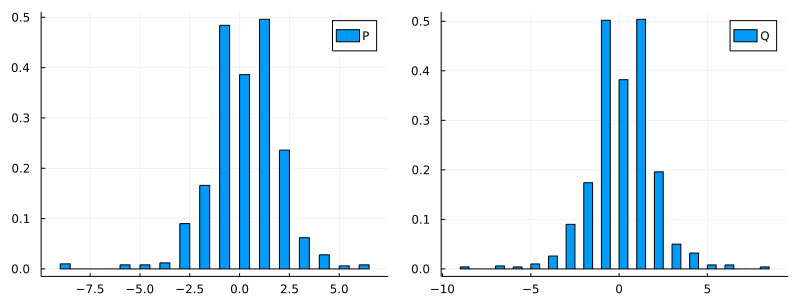

In [209]:
Pavg = [(p[1]-p[2]) for p in popP]
Qavg = [(p[1]-p[2]) for p in popQ]
p1 = histogram(Pavg, label="P", normalize=:true)
p2 = histogram(Qavg, label="Q", normalize=true)
plot(p1,p2, size=(800,300))

In [202]:
include("../code/rs.jl")
R_rs, D_rs, P_rs = RS(Pk, Λ; N=1000, tol=1e-5, maxiter=100, damp=0.9)

Fia = -18.78494443892439
Fi = 17.55687192237383
Fa = 0.7400135221223797


(0.25, 0.2559705027859091, [1.684330175508914e-5, 1.684330175508914e-5, 1.6843301755089138e-5, 1.6843301755089138e-5, 1.684330175508914e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5  …  1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.6843301755089145e-5, 1.684330175508914e-5, 1.6843301755089138e-5, 1.6843301755089138e-5, 1.684330175508914e-5, 1.684330175508914e-5])

In [220]:
dd(o) = (1-o)/2
dd(-18.78494443892439), dd(17.55687192237383), dd(0.7400135221223797)

(9.892472219462196, -8.278435961186915, 0.12999323893881015)

In [215]:
F = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^4)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.0, 0.0, -4.5)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5, 0.0, -3.0)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6666666666666666, 0.25, -3.0)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5, 0.375, -2.25)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6, 0.3, -2.1)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6666666666666666, 0.25, -3.0)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.7142857142857143, 0.21428571428571427, -2.5714285714285716)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.625, 0.28125, -2.4375)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5555555555555556, 0.25, -2.1666666666666665)
((Fi / t) / log2(Q), ((α

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5316455696202531, 0.26582278481012656, -0.759493670886076)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.55, 0.2625, -0.75)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5432098765432098, 0.2777777777777778, -0.7407407407407407)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5487804878048781, 0.27439024390243905, -0.7317073170731707)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5542168674698795, 0.28012048192771083, -0.7409638554216867)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5595238095238095, 0.2767857142857143, -0.7321428571428571)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5529411764705883, 0.2735294117647059, -0.7235294117647059)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5714285714285714, 0.35064935064935066, -0.75)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.567741935483871, 0.34838709677419355, -0.7548387096774194)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5641025641025641, 0.34615384615384615, -0.7596153846153846)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5668789808917197, 0.34394904458598724, -0.7547770700636943)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.569620253164557, 0.34177215189873417, -0.75)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5723270440251572, 0.33962264150943394, -0.7547169811320755)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.575, 0.3375, -0.75)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.58

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5859030837004405, 0.31387665198237885, -0.7268722466960352)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5921052631578947, 0.3125, -0.7302631578947368)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5938864628820961, 0.314410480349345, -0.7270742358078602)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.591304347826087, 0.3130434782608696, -0.7304347826086957)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5930735930735931, 0.3116883116883117, -0.7272727272727273)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5905172413793104, 0.3103448275862069, -0.7241379310344828)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592274678111588, 0.3090128755364807, -0.721030042918455)
((Fi / t) / log2(Q), ((α * Fa) / t)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5813953488372093, 0.31893687707641194, -0.6627906976744186)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5827814569536424, 0.320364238410596, -0.6605960264900662)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5808580858085809, 0.3193069306930693, -0.6584158415841584)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5789473684210527, 0.3207236842105263, -0.65625)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.580327868852459, 0.319672131147541, -0.6540983606557377)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5816993464052288, 0.31862745098039214, -0.6568627450980392)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5830618892508144, 0.31758957654723124, -0.6644951140065146)
((Fi / t) / log2(Q), ((α * Fa) 

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5909090909090909, 0.32085561497326204, -0.6336898395721925)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592, 0.32, -0.636)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5904255319148937, 0.3211436170212766, -0.6343085106382979)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5888594164456233, 0.3222811671087533, -0.6326259946949602)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5925925925925926, 0.32142857142857145, -0.6349206349206349)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910290237467019, 0.32058047493403696, -0.633245382585752)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5921052631578947, 0.31973684210526315, -0.6355263157894737)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fi

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5950782997762863, 0.3087248322147651, -0.6174496644295302)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959821428571429, 0.3080357142857143, -0.6160714285714286)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5946547884187082, 0.30734966592427615, -0.6146993318485523)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955555555555555, 0.30666666666666664, -0.6133333333333333)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5942350332594235, 0.30598669623059865, -0.61529933481153)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5929203539823009, 0.3053097345132743, -0.6172566371681416)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5960264900662252, 0.304635761589404, -0.6158940397350994)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6257197696737045, 0.29366602687140114, -0.581573896353167)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6245210727969349, 0.29310344827586204, -0.5833333333333334)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6233269598470363, 0.2925430210325048, -0.5822179732313576)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6240458015267175, 0.2919847328244275, -0.5811068702290076)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6247619047619047, 0.2914285714285714, -0.58)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.623574144486692, 0.29230038022813687, -0.5817490494296578)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6223908918406073, 0.29316888045540795, -0.5806451612903226)
((Fi / t) / log2(Q), ((α * Fa) /

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6172006745362564, 0.28583473861720066, -0.5919055649241147)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6178451178451179, 0.28535353535353536, -0.5934343434343434)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6168067226890757, 0.2848739495798319, -0.5949579831932773)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6157718120805369, 0.28439597315436244, -0.5939597315436241)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6147403685092128, 0.2851758793969849, -0.592964824120603)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6137123745819398, 0.2846989966555184, -0.596989966555184)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6176961602671118, 0.2854757929883139, -0.5984974958263773)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5937031484257871, 0.29347826086956524, -0.6026986506746627)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592814371257485, 0.2930389221556886, -0.6017964071856288)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5919282511210763, 0.297085201793722, -0.600896860986547)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5925373134328358, 0.29776119402985074, -0.6022388059701492)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5916542473919523, 0.29731743666169896, -0.6035767511177347)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5922619047619048, 0.29799107142857145, -0.6049107142857143)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5913818722139673, 0.2986627043090639, -0.6040118870728083)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5967523680649527, 0.29837618403247634, -0.6008119079837618)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.595945945945946, 0.297972972972973, -0.6)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5951417004048583, 0.2975708502024291, -0.6032388663967612)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5970350404312669, 0.29818059299191374, -0.6044474393530997)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5962314939434724, 0.29878869448183043, -0.6036339165545087)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5967741935483871, 0.29838709677419356, -0.6028225806451613)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5973154362416108, 0.2979865771812081, -0.6040268456375839)
((Fi / t) / log2(Q), ((α * Fa) / 

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5867158671586716, 0.3081180811808118, -0.6236162361623616)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5872235872235873, 0.30773955773955775, -0.6246928746928747)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5877300613496933, 0.30736196319018405, -0.6239263803680981)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5870098039215687, 0.3069852941176471, -0.6231617647058824)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5862913096695227, 0.30660954712362304, -0.6242350061199511)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5855745721271394, 0.30623471882640585, -0.6271393643031785)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5860805860805861, 0.3076923076923077, -0.6263736263736264)
((Fi / t) / log2

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5801354401805869, 0.310665914221219, -0.621331828442438)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5794813979706878, 0.3111612175873732, -0.6240135287485907)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.579954954954955, 0.31165540540540543, -0.625)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5815523059617548, 0.31214848143982005, -0.6242969628796401)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5808988764044943, 0.31264044943820224, -0.6235955056179775)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5802469135802469, 0.3122895622895623, -0.6245791245791246)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5807174887892377, 0.3119394618834081, -0.6238789237668162)
((Fi / t) / log2(Q), ((α * Fa) / 

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5787278415015641, 0.3112617309697602, -0.6225234619395204)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5791666666666667, 0.3109375, -0.621875)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5796045785639958, 0.3113943808532778, -0.6212278876170656)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.579002079002079, 0.31107068607068605, -0.6205821205821206)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5784008307372793, 0.3115264797507788, -0.6199376947040498)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5778008298755186, 0.3119813278008299, -0.6192946058091287)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5772020725388601, 0.3116580310880829, -0.6202072538860104)
((Fi / t) / log2(Q), ((α * Fa) / t) / l

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5866408518877058, 0.30493707647628265, -0.6084220716360116)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5870406189555126, 0.30464216634429403, -0.6078336557059961)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5864734299516908, 0.30579710144927535, -0.6072463768115942)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5859073359073359, 0.3055019305019305, -0.6066602316602316)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5853423336547734, 0.3052073288331726, -0.6060752169720347)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5867052023121387, 0.30491329479768786, -0.6069364161849711)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5861405197305101, 0.3046198267564966, -0.6063522617901829)
((Fi / t) / log2

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5918552036199095, 0.3006787330316742, -0.606787330316742)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5922242314647378, 0.3010849909584087, -0.60623869801085)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5916892502258356, 0.3008130081300813, -0.6056910569105691)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592057761732852, 0.30054151624548736, -0.60514440433213)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5915238954012624, 0.30027051397655546, -0.6045987376014428)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.590990990990991, 0.3, -0.6054054054054054)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5904590459045904, 0.29972997299729975, -0.6062106210621062)
((Fi / t) / log2(Q), ((α * Fa) / t) / l

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5916808149405772, 0.29796264855687604, -0.6022920203735145)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5920271416454622, 0.29834605597964375, -0.6017811704834606)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5915254237288136, 0.29809322033898306, -0.6025423728813559)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5918712955122777, 0.2978408128704488, -0.6020321761219306)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5922165820642978, 0.2982233502538071, -0.6027918781725888)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5925612848689772, 0.2986052409129332, -0.6022823330515639)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5920608108108109, 0.2983530405405405, -0.6017736486486487)
((Fi / t) / log2(

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5915267785771383, 0.3009592326139089, -0.6007194244604317)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.59185303514377, 0.3007188498402556, -0.6014376996805112)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5913806863527534, 0.30107741420590584, -0.6009577015163607)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5917065390749602, 0.3008373205741627, -0.6004784688995215)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5912350597609561, 0.301195219123506, -0.6)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5915605095541401, 0.3021496815286624, -0.5995222929936306)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5918854415274463, 0.301909307875895, -0.5990453460620525)
((Fi / t) / log2(Q), ((α * Fa) / t) / 

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.600754716981132, 0.3039622641509434, -0.5977358490566038)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6010558069381599, 0.3037330316742081, -0.5984162895927602)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.60060286360211, 0.3035041446872645, -0.5990957045968349)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6001506024096386, 0.3032756024096386, -0.598644578313253)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.600451467268623, 0.3030474040632054, -0.5993227990970654)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6007518796992481, 0.30281954887218043, -0.5988721804511278)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.6003005259203607, 0.30259203606311047, -0.5984222389181066)
((Fi / t) / log2(Q), ((

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5941302791696492, 0.3027916964924839, -0.58840372226199)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5937052932761088, 0.30257510729613735, -0.5879828326180258)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5939957112223017, 0.3023588277340958, -0.5886347390993567)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5935714285714285, 0.3026785714285714, -0.5892857142857143)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5931477516059958, 0.3024625267665953, -0.5899357601713062)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5934379457917262, 0.30331669044222537, -0.5895149786019972)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5930149679258732, 0.30310049893086244, -0.5890947968638631)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.591156462585034, 0.3025510204081633, -0.5846938775510204)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5907545887151597, 0.30285520054384774, -0.5842963970088375)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5903532608695652, 0.3031589673913043, -0.5838994565217391)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5906313645621182, 0.3034623217922607, -0.5835030549898167)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5909090909090909, 0.30325644504748983, -0.5831071913161465)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5905084745762712, 0.3035593220338983, -0.5827118644067797)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5907859078590786, 0.30335365853658536, -0.5823170731707317)
((Fi / t) / log2(Q

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5962410887880751, 0.3028191834089436, -0.5755022683084899)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5965025906735751, 0.30359455958549225, -0.5751295336787565)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5967637540453075, 0.30339805825242716, -0.5757281553398058)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5963777490297542, 0.3032018111254851, -0.5782664941785253)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959922430510666, 0.30349062702003876, -0.5778926955397543)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5962532299741602, 0.30329457364341084, -0.5784883720930233)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958683021304068, 0.30358295674628794, -0.578114912846998)
((Fi / t) / log2

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956656346749226, 0.30371517027863776, -0.58328173374613)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959158415841584, 0.3035272277227723, -0.5829207920792079)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5961657390228818, 0.3033395176252319, -0.5825602968460112)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.595797280593325, 0.3031520395550062, -0.5831273176761433)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5960469425571341, 0.30342804200123535, -0.5836936380481779)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5962962962962963, 0.3037037037037037, -0.5833333333333334)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5965453423812461, 0.30351634793337445, -0.5829734731647132)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959715639810427, 0.3012440758293839, -0.5873815165876777)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956187092954411, 0.30150976909413857, -0.5879218472468917)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5964497041420118, 0.30133136094674556, -0.5875739644970415)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5966883500887049, 0.3011531638083974, -0.5872264931992903)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5969267139479906, 0.30097517730496454, -0.5868794326241135)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.596574128765505, 0.3007974010632014, -0.5865327820437094)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5962219598583235, 0.3006198347107438, -0.5861865407319953)
((Fi / t) / log2(Q

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956842703009654, 0.2989778534923339, -0.5919931856899489)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5953461975028377, 0.29880817253121456, -0.5925085130533485)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955757231990925, 0.2986386840612592, -0.5921724333522405)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5952380952380952, 0.29846938775510207, -0.5918367346938775)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5954674220963173, 0.2987252124645892, -0.5940509915014164)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956964892412231, 0.29855605889014725, -0.5937146092865232)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959252971137521, 0.29838709677419356, -0.5950764006791172)
((Fi / t) / log2

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5971615720524017, 0.298853711790393, -0.5919759825327511)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5973813420621932, 0.2986906710310966, -0.5916530278232406)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5976008724100327, 0.2985278080697928, -0.591330425299891)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5978201634877384, 0.29836512261580383, -0.591008174386921)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5980392156862745, 0.2986111111111111, -0.5923202614379085)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.597713663581927, 0.29844855743059334, -0.5919978225367447)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5973884657236126, 0.2982861806311208, -0.5916757344940152)
((Fi / t) / log2(Q), (

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958005249343832, 0.29606299212598425, -0.5952755905511811)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5954879328436516, 0.29590766002098634, -0.5949632738719832)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5957000524383849, 0.29575249082328264, -0.5946512847404299)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5959119496855346, 0.29559748427672955, -0.5943396226415094)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955997904662127, 0.29544264012572025, -0.5940282870612886)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958115183246073, 0.29528795811518327, -0.5945026178010471)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5954997383568812, 0.29513343799058084, -0.5941915227629513)
((Fi / t) / l

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5978755690440061, 0.2936267071320182, -0.6016691957511381)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5975733063700708, 0.29347826086956524, -0.602881698685541)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5972713491662456, 0.2933299646286003, -0.6025770591207681)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.597979797979798, 0.29393939393939394, -0.6022727272727273)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5976779404341241, 0.2945482079757698, -0.6027258960121151)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5978809283551968, 0.29477800201816345, -0.6024217961654894)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5975794251134644, 0.2957639939485628, -0.6021180030257186)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5948317893710385, 0.295831301803998, -0.5989761092150171)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955165692007798, 0.295687134502924, -0.5986842105263158)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5952264978080857, 0.29554310764734537, -0.598392596200682)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5954235637779941, 0.2953992210321324, -0.5981012658227848)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956204379562043, 0.29525547445255473, -0.5978102189781022)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958171206225681, 0.29511186770428016, -0.5975194552529183)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955274671852212, 0.29496840058337387, -0.5979581915410792)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5939707960433349, 0.2921573245407442, -0.5942063118228922)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5936911487758946, 0.2920197740112994, -0.594632768361582)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5934117647058823, 0.29223529411764704, -0.5950588235294118)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5936030103480715, 0.2920978363123236, -0.5947789275634995)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5933239304184297, 0.2919605077574048, -0.5952045133991537)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5935150375939849, 0.2918233082706767, -0.5963345864661654)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.593236261155472, 0.29168623767026775, -0.5967590418036637)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5938069216757741, 0.2947404371584699, -0.6058743169398907)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.593536640873919, 0.2946062812926718, -0.605598543468366)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5932666060054596, 0.2944722474977252, -0.6053230209281165)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5929968167348795, 0.29536152796725784, -0.6050477489768077)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5927272727272728, 0.2952272727272727, -0.6047727272727272)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5924579736483416, 0.2950931394820536, -0.6051794638800545)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592188919164396, 0.2949591280653951, -0.6055858310626703)
((Fi / t) / log2(Q), (

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5901278096077567, 0.29418245923314235, -0.6022476862053768)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5903083700440529, 0.2943832599118943, -0.6019823788546256)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5904887714663144, 0.2942536327608983, -0.6017173051519155)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5902288732394366, 0.2941241197183099, -0.6014524647887324)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5899692036955565, 0.293994720633524, -0.6011878574571051)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5897097625329816, 0.2941952506596306, -0.6009234828496042)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5894505494505494, 0.29406593406593406, -0.6006593406593407)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5899188381033746, 0.29859034600598033, -0.5997436992738147)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5900939368061486, 0.29846285226302305, -0.6001280956447481)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5898420827998293, 0.2986555697823303, -0.6005121638924455)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5895904436860068, 0.29948805460750855, -0.6002559726962458)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5893390191897655, 0.29936034115138593, -0.6)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5895140664961637, 0.29923273657289, -0.5997442455242967)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5896889646357052, 0.29910524073285044, -0.5994887089902002)
((Fi / t) / log2(Q), ((α * Fa) /

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956917978458989, 0.2973280861640431, -0.5940347970173985)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958592132505176, 0.29720496894409937, -0.5937888198757764)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5956125827814569, 0.2977028145695364, -0.5935430463576159)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5957798924286305, 0.29757964418700866, -0.5945386843194043)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5955334987593052, 0.29745657568238215, -0.5942928039702233)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5952873088052915, 0.29764365440264573, -0.5952873088052915)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5958677685950413, 0.2975206611570248, -0.5956611570247934)
((Fi / t) / log2

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5963007639726579, 0.29764776839565743, -0.5916767189384801)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5960610932475884, 0.2975281350482315, -0.5914389067524116)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5966251506629169, 0.297408597830454, -0.5918039373242266)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5963855421686747, 0.297289156626506, -0.5921686746987952)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5961461260537937, 0.2971698113207547, -0.5919309514251305)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5963081861958266, 0.29735152487961475, -0.5922953451043339)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5960689931809066, 0.2972322503008424, -0.592057761732852)
((Fi / t) / log2(Q), 

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.593200468933177, 0.2963071512309496, -0.5902696365767878)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.593359375, 0.29619140625, -0.5912109375)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5931276844982428, 0.2963686060132761, -0.5915657946114798)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592896174863388, 0.2962529274004684, -0.5913348946135831)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.593055013655872, 0.296137339055794, -0.591689426453375)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.592823712948518, 0.2960218408736349, -0.5914586583463338)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5929824561403508, 0.29619883040935674, -0.5912280701754385)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5934650455927052, 0.29492781155015196, -0.5898556231003039)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5932396505886821, 0.2948157994682871, -0.5896315989365742)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5933940774487472, 0.29470387243735763, -0.5905466970387244)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5939278937381404, 0.29459203036053133, -0.5908918406072107)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5937025796661608, 0.2947647951441578, -0.5906676783004552)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5938566552901023, 0.2949374288964733, -0.590443686006826)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5936315390447309, 0.29482562547384383, -0.5902198635329795)
((Fi / t) / log2(

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5914972273567468, 0.2933456561922366, -0.5916820702402957)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5916481892091648, 0.29351441241685144, -0.5914634146341463)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5917990395271518, 0.29340598448466937, -0.5912449205762838)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5915805022156573, 0.2935745937961595, -0.59102658788774)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5917312661498708, 0.29346622369878184, -0.5908084163898117)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5922509225092251, 0.2933579335793358, -0.5905904059040591)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5920324603467355, 0.2938030247141276, -0.5903725562523054)
((Fi / t) / log2(Q)

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5916456607850198, 0.29276197335253873, -0.5887648541591646)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5914326853851691, 0.29292656587473004, -0.5885529157667386)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5912198632601655, 0.29282115869017633, -0.5883411299028427)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910071942446044, 0.2927158273381295, -0.5881294964028777)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.590794678173319, 0.2928802588996764, -0.5879180151024811)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.590941768511862, 0.2927749820273185, -0.5877066858375269)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910887531440892, 0.2932087675170679, -0.587495508444125)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5898245614035088, 0.2942105263157895, -0.5863157894736842)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5896176780077166, 0.29463346194317785, -0.5866362679761488)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5894109396914446, 0.29453015427769985, -0.5864305750350631)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5892043463021381, 0.29442691903259727, -0.5862250262881178)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5889978976874563, 0.2945865451997197, -0.5860196215837421)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5887915936952715, 0.29448336252189145, -0.5858143607705779)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5892857142857143, 0.29464285714285715, -0.5861344537815126)
((Fi / t) / log

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5901471091344509, 0.2937906260691071, -0.5839890523434828)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5899452804377565, 0.29369015047879615, -0.5843023255813954)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5900854700854701, 0.2935897435897436, -0.5841025641025641)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5898838004101162, 0.29374572795625425, -0.5849282296650717)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5896822685343355, 0.2939016057396652, -0.5847283908438674)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5894808743169399, 0.2938012295081967, -0.5845286885245902)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5892796176169341, 0.29370092181631957, -0.5843291225674292)
((Fi / t) / log2(

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5909849749582637, 0.29373956594323875, -0.5879799666110184)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5907877169559412, 0.2936415220293725, -0.5887850467289719)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5905905905905906, 0.29354354354354356, -0.5885885885885885)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.590393595730487, 0.2934456304202802, -0.5883922615076718)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5901967322440813, 0.2933477825941981, -0.5881960653551184)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.59, 0.29325, -0.588)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5898033988670444, 0.293402199266911, -0.5878040653115628)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5914574502771438, 0.2944245190740137, -0.5854254972285621)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5912646675358539, 0.2943285528031291, -0.5857235984354628)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910720104268491, 0.29423264907135877, -0.5860215053763441)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5908794788273616, 0.29413680781758955, -0.5858306188925081)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5906870726147835, 0.29404102898078804, -0.585639856724194)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5904947916666666, 0.2939453125, -0.58544921875)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5903026358607224, 0.29409371949235275, -0.585746827204686)
((Fi / t) / log2(Q), ((α * Fa

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910828025477707, 0.293312101910828, -0.5894904458598726)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5912129894937918, 0.2934574976122254, -0.5893027698185291)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5910248249522597, 0.29336409929980906, -0.5891152132399745)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5911549475023863, 0.29398663697104677, -0.5889277760101813)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5912849872773537, 0.29389312977099236, -0.5892175572519084)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5917329093799683, 0.29379968203497614, -0.5895071542130366)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5918626827717737, 0.2937062937062937, -0.589319771137953)
((Fi / t) / log2(Q

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5882352941176471, 0.2931839402427638, -0.5891690009337068)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5880522713130056, 0.2933260734287492, -0.588985687616677)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5881804043545878, 0.2932348367029549, -0.5892690513219284)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5883084577114428, 0.2931436567164179, -0.5890858208955224)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5881255828411563, 0.2930525334162263, -0.5893689773080509)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5879428216283406, 0.2929614667495339, -0.5891858297078931)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5880708294501398, 0.29310344827586204, -0.5890027958993477)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.589041095890411, 0.2924657534246575, -0.5904109589041096)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5888618381010347, 0.29237674984783935, -0.5906877662811929)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5886826893824155, 0.2922878004259203, -0.5914207484027989)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5894160583941606, 0.29242700729927007, -0.5912408759124088)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.58954089388872, 0.29233809668592275, -0.5910611128002432)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5896656534954408, 0.2924772036474164, -0.5908814589665653)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5897903372835005, 0.2923883318140383, -0.5907019143117593)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5884455032757594, 0.2912447885646218, -0.5896366885050626)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5882703185471867, 0.291381363501042, -0.5894611491515332)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5886904761904762, 0.29129464285714285, -0.5892857142857143)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.588812853317465, 0.2914311216899732, -0.589110383814341)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5889351576442594, 0.29134443783462227, -0.5889351576442594)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5896520963425513, 0.29125780553077607, -0.5887600356824264)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5897740784780023, 0.2911712247324614, -0.5894768133174791)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5884581754590499, 0.291168755464879, -0.5928300786942582)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5882867132867133, 0.2910839160839161, -0.5926573426573427)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5884066414214972, 0.29099912612875034, -0.5924847072531314)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5882352941176471, 0.2909143855562027, -0.5923121723937099)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5883551673944687, 0.2910480349344978, -0.5921397379912664)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5884749708963911, 0.29096332945285214, -0.5919674039580908)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5888856560954321, 0.2908786732615653, -0.592231597323247)
((Fi / t) / log2(Q),

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5874964316300314, 0.29075078504139307, -0.5939194975735084)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5873287671232876, 0.2906678082191781, -0.5941780821917808)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5877318116975749, 0.2905848787446505, -0.5940085592011413)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5878494010268112, 0.2905019965772961, -0.5938391329150029)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5879669232962647, 0.2904191616766467, -0.5936698032506416)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5877993158494869, 0.2903363740022805, -0.5935005701254276)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5876318039327444, 0.29046736962097464, -0.5937589056711314)
((Fi / t) / log2(Q

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.587248322147651, 0.2898489932885906, -0.5914429530201343)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5876432764886776, 0.28976796197931226, -0.5912776069331842)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5877585243152599, 0.2896869759642258, -0.5911123532699832)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5875943000838223, 0.28960603520536465, -0.5909471919530596)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.587709497206704, 0.2895251396648045, -0.5912011173184357)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5878246299916224, 0.2894442893046635, -0.5910360234571349)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5876605248464545, 0.28936348408710216, -0.5912897822445561)
((Fi / t) / log2(Q)

Excessive output truncated after 524312 bytes.

((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.587010139764319, 0.28898328309125787, -0.5874212112907646)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5868493150684931, 0.2889041095890411, -0.5872602739726027)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.587236373596275, 0.2888249794576828, -0.5875102711585867)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5876232201533407, 0.2887458926615553, -0.5873493975903614)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5874623597043526, 0.28887215986860115, -0.5871886120996441)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.5873015873015873, 0.28879310344827586, -0.5870279146141215)
((Fi / t) / log2(Q), ((α * Fa) / t) / log2(Q), ((-mΛ * Fia) / t) / log2(Q)) = (0.587140902872777, 0.2887140902872777, -0.5872777017783858)
((Fi / t) / log2(Q),

0.30145

In [186]:
[collect(sort(proportionmap(P)))[2:end-1] P_rs[-7:7]]

15×2 Matrix{Any}:
 -7.0=>0.0005  0.000460436
 -6.0=>0.0018  0.00143306
 -5.0=>0.0057  0.00430686
 -4.0=>0.0157  0.0124397
 -3.0=>0.0364  0.0347138
 -2.0=>0.1037  0.0943782
 -1.0=>0.2479  0.252122
  0.0=>0.1712  0.166482
  1.0=>0.2493  0.252122
  2.0=>0.1086  0.0943782
  3.0=>0.0389  0.0347138
  4.0=>0.0133  0.0124397
  5.0=>0.0034  0.00430686
  6.0=>0.0019  0.00143306
  7.0=>0.001   0.000460436

In [174]:
sum(P_rs)

1.0000000000000013

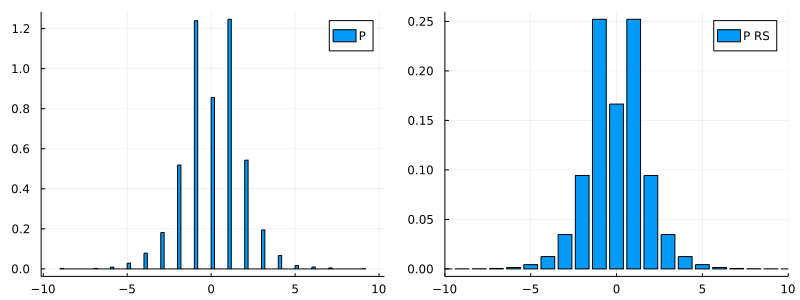

In [173]:
J = lastindex(P_rs)
p3 = bar(-J:J, P_rs.parent, label="P RS")
xlims!(p3, (-10,10))
plot(p1,p3, size=(800,300))

In [216]:
mK = sum(k*Pk[k] for k=eachindex(Pk))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
R=1-α

0.25

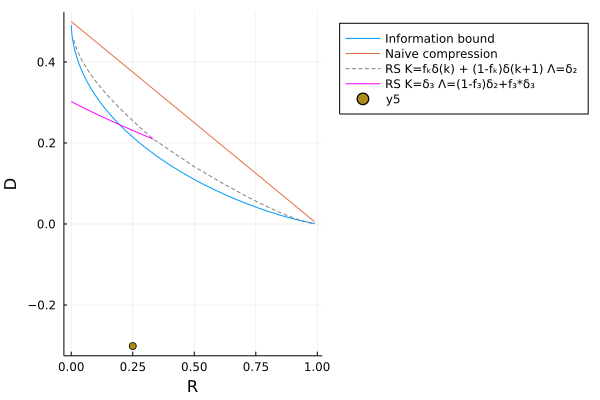

In [219]:
plot_rdb()
scatter!([R], [-F], legend=:outertopright)